In [17]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from termcolor import colored
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

# Bibliotecas usadas

| Biblioteca | Descrição |
|---|---|
| **pandas** | Biblioteca para manipulação e análise de dados. Oferece estruturas como DataFrames para organização e análise eficiente de dados. |
| **yfinance** | Biblioteca para baixar dados financeiros históricos, como preços de ações, do Yahoo Finance. |
| **sklearn.model_selection** | Módulo do scikit-learn para dividir dados em conjuntos de treinamento e teste, essenciais para avaliação de modelos e prevenção de overfitting. A função `train_test_split` é fundamental. |
| **matplotlib.pyplot** | Interface para criação de gráficos em matplotlib, semelhante ao MATLAB. Permite gerar diversos tipos de gráficos. |
| **termcolor** | Biblioteca para imprimir texto colorido no terminal, melhorando a apresentação visual dos resultados. |
| **sklearn.metrics** | Módulo do scikit-learn com métricas para avaliar a performance de modelos de machine learning, como MAE, RMSE e MAPE. |
| **xgboost** | Biblioteca de alto desempenho para implementação de algoritmos de gradient boosting, conhecidos por sua precisão e eficiência. |


* Para uma descrição mais detalhada, consulte a documentação oficial de cada biblioteca.



In [18]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
class ForecastPetroleo():
    """
    Classe para previsão de preços de petróleo utilizando dados históricos e do IPEADATA.

    Atributos:
        ticker (str): O ticker do petróleo (padrão: "BZ=F").
        df (pd.DataFrame): DataFrame contendo os dados combinados do IPEADATA e Yahoo Finance.
        df_yf (pd.DataFrame): DataFrame contendo os dados do Yahoo Finance.

    Métodos:
        __init__(self, ticker="BZ=F"): Inicializa a classe e carrega os dados.
        fit(self): Método placeholder para ajuste do modelo (atualmente não faz nada).
        download_yahoo_finance(self, ticker, start_date="2025-01-01"): Baixa dados do Yahoo Finance.        
        create_features(self, df): Cria features a partir dos dados do Yahoo Finance ou IPEA DATA.
        calculate_metrics(self, y_true, y_pred): Calcula métricas de avaliação do modelo.
        print_metrics(self, metrics): Imprime as métricas de avaliação.
        prepare_data(self): Prepara os dados para treinamento e teste.
        train_model(self, X_train, y_train): Treina o modelo XGBoost.
        evaluate_model(self, model, X_test, y_test): Avalia o modelo e imprime as métricas.
        plot_predictions_with_test(self, y_test, y_pred): Plota as previsões com os valores reais (teste).
        plot_predictions(self, y_pred): Plota as previsões finais.
        configure_days(self, first_date, num_days=1): Configura as datas futuras para previsão.
        prepare_dates(self, dates): Prepara as datas para serem usadas como features.
        final_predictions(self, dates_for_predict, y_pred_final): Combina as datas futuras com as previsões.
        predict_days(self, days=10): Realiza a previsão para os próximos dias.

    """
    def __init__(self, ticker="BZ=F"):
        """
        Inicializa a classe ForecastPetroleo.

        Args:
            ticker (str): O ticker do petróleo (padrão: "BZ=F").
        """
        self.ticker = ticker        
        df_ipeadata = pd.read_csv('ipeadata[09-02-2025-09-30].csv')
        self.df = self.create_features(df_ipeadata, source="ipeadata")
        data_inicio = self.df.index[-1] + pd.Timedelta(days=1)
        self.df_yf = self.download_yahoo_finance(ticker, start_date=data_inicio)
        self.df = pd.concat([self.df, self.df_yf], axis=0)
        
    def fit(self):
        """
        Método placeholder para ajuste do modelo (atualmente não faz nada).

        Returns:
            ForecastPetroleo: Retorna a própria instância da classe.
        """
        return self
    
    def download_yahoo_finance(self, ticker, start_date="2025-01-01"):
        """
        Baixa dados do Yahoo Finance.

        Args:
            ticker (str): O ticker do ativo.
            start_date (str): Data de início para o download (padrão: "2025-01-01").

        Returns:
            pd.DataFrame: DataFrame com os dados baixados.
        """
        data_frame = yf.download(ticker, start=start_date)        
        data_frame = self.create_features(data_frame, source="yfinance")        
        return data_frame
    
    def create_features(self, df, source="ipeadata"):
        """
        Cria novas feature a partir de um DataFrame, tratando tanto dados do Ipeadata quanto de yfinance

        Argumentos:
            df: O DataFrame de entrada.
            source: A fonte dos dados ("ipeadata" ou "yfinance").

        Retorno:
            Um DataFrame com as features criadas.
        """
        data_frame = df.copy()

        if source == "ipeadata":
            data_frame.drop(columns=['Unnamed: 2'], inplace=True, errors='ignore') # remove coluna não utilizada e se não existir será ignorado o erro
            data_frame.columns = ['data', 'valor_fechamento'] # renomeia as colunas
            data_frame['data'] = pd.to_datetime(data_frame["data"], format='%d/%m/%Y', errors='coerce') # converte a coluna data para datetime
            data_frame.dropna(inplace=True)  # remove linhas com valores nulos
            data_frame.set_index('data', inplace=True) # define a coluna data como índice

        elif source == "yfinance":
            data_frame["data"] = pd.to_datetime(df.index)  # cria uma nova coluna com a data
            data_frame.rename(columns={'Close': 'valor_fechamento'}, inplace=True, errors='ignore')  # renomeia a coluna Close para valor_fechamento
            data_frame.rename(columns={'Open': 'valor_abertura'}, inplace=True, errors='ignore')  # renomeia a coluna Open para valor_abertura

        else:
            raise ValueError("dados inválidos as origem devem ser de 'ipeadata' ou 'yfinance'.") # levanta um erro se a origem dos dados for inválida

        data_frame['ano'] = data_frame.index.year  # cria uma coluna com o ano
        data_frame['mes'] = data_frame.index.month # cria uma coluna com o mês
        data_frame['dia'] = data_frame.index.day # cria uma coluna com o dia
        data_frame['dia_da_semana'] = data_frame.index.dayofweek # cria uma coluna com o dia da semana

        return data_frame
    
    def calculate_metrics(self, y_true, y_pred):
        """
        Calcula as métricas de erro para avaliar o desempenho do modelo.

        Args:
            y_true (pd.Series ou np.array): Valores reais (verdadeiros) do alvo.
            y_pred (pd.Series ou np.array): Valores previstos pelo modelo.

        Returns:
            tuple: Uma tupla contendo o Erro Absoluto Médio (MAE), a Raiz do Erro Quadrático Médio (RMSE) e o Erro Percentual Absoluto Médio (MAPE).
        """
        mae = mean_absolute_error(y_true, y_pred)
        mse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape


    def print_metrics(self, metrics):
        """
        Imprime as métricas de avaliação do modelo formatadas e coloridas.

        Args:
            metrics (tuple): Uma tupla contendo o MAE, RMSE (ou MSE) e MAPE.  Espera-se que as métricas estejam nesta ordem.
        """
        mae, mse, mape = metrics
        print(colored(f"MAE: {mae}", 'light_blue'))
        print(colored(f"MSE: {mse}", 'light_cyan'))
        print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

    def prepare_data(self):
        """
        Prepara os dados para treinamento e teste, separando features (X) e target (y),
        e dividindo-os em conjuntos de treinamento e teste.

        Returns:
            tuple: Uma tupla contendo X_train, X_test, y_train e y_test.
        """
        df_feature = self.df.copy()  # Cria uma cópia para não modificar o DataFrame original
        df_feature.sort_values(by='data', inplace=True) # Ordena os dados pela data

        feature_names = ["ano", "mes", "dia", "dia_da_semana"] # Define as colunas que serão usadas como features
        target = "valor_fechamento" # Define a coluna que será usada como target (valor a ser previsto)

        X = df_feature[feature_names] # Seleciona as features
        y = df_feature[target] # Seleciona o target

        # Divide os dados em treinamento e teste.  `shuffle=False` mantém a ordem cronológica, importante para séries temporais.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.008, shuffle=False) # Test_size de 0.8%

        print(f"X_train: {X_train.shape}") # Imprime as dimensões do conjunto de treinamento
        print(f"X_test: {X_test.shape}") # Imprime as dimensões do conjunto de teste

        return X_train, X_test, y_train, y_test # Retorna os conjuntos de dados
    
    def train_model(self, X_train, y_train):
        """
        Treina o modelo XGBoost Regressor com os dados de treinamento.

        Args:
            X_train (pd.DataFrame ou np.array): Features de treinamento.
            y_train (pd.Series ou np.array): Target de treinamento.

        Returns:
            xgb.XGBRegressor: O modelo XGBoost treinado.
        """
        model = xgb.XGBRegressor(objective="reg:squarederror")  # Instancia o modelo XGBoost
        model.fit(X_train, y_train)  # Treina o modelo com os dados de treinamento
        return model  # Retorna o modelo treinado
    
    def evaluate_model(self, model, X_test, y_test):
        """
        Avalia o modelo treinado com os dados de teste, calcula as métricas de erro
        e as imprime.

        Args:
            model (xgb.XGBRegressor): O modelo XGBoost treinado.
            X_test (pd.DataFrame ou np.array): Features de teste.
            y_test (pd.Series ou np.array): Target de teste.

        Returns:
            np.array: Um array com as previsões do modelo para os dados de teste (`y_pred`).
        """
        y_pred = model.predict(X_test)  # Faz as previsões com o modelo nos dados de teste
        mae, mse, mape = self.calculate_metrics(y_test, y_pred)  # Calcula as métricas de erro
        self.print_metrics((mae, mse, mape))  # Imprime as métricas formatadas
        return y_pred  # Retorna as previsões
    def plot_predictions_with_test(self, y_test, y_pred):
        """
        Plota os valores reais e previstos para o conjunto de teste.

        Args:
            y_test (pd.Series ou np.array): Valores reais do target para o conjunto de teste.
            y_pred (np.array): Valores previstos pelo modelo para o conjunto de teste.
        """
        plt.plot(y_test.index, y_test, label="Valor Real")  # Plota os valores reais
        plt.plot(y_test.index, y_pred, label="Valor Previsto (Teste)")  # Plota os valores previstos
        plt.legend()  # Exibe a legenda
        plt.xticks(rotation=45, ha='right')  # Rotaciona os ticks do eixo x para melhor visualização
        plt.title("Comparação: Valores Reais vs. Previsões (Teste)") # Adiciona um título ao gráfico
        plt.xlabel("Data") # Adiciona um label para o eixo x
        plt.ylabel("Valor") # Adiciona um label para o eixo y
        plt.tight_layout() # Ajusta o layout do gráfico para evitar cortes
        plt.show()  # Exibe o gráfico

    def plot_predictions(self, y_pred):
        """
        Plota as previsões finais do modelo.

        Args:
            y_pred (pd.DataFrame): DataFrame contendo as previsões, com um índice de data e a coluna 'valor_fechamento'.
        """
        plt.plot(y_pred.index, y_pred['valor_fechamento'], label="Valor Previsto")  # Plota os valores previstos
        plt.legend()  # Exibe a legenda
        plt.xticks(rotation=45, ha='right')  # Rotaciona os ticks do eixo x para melhor visualização
        plt.title("Previsões Finais")  # Adiciona um título ao gráfico
        plt.xlabel("Data")  # Adiciona um label para o eixo x
        plt.ylabel("Valor")  # Adiciona um label para o eixo y
        plt.tight_layout()  # Ajusta o layout do gráfico
        plt.show()  # Exibe o gráfico

    def configure_days(self, first_date, num_days=1):
        """
        Gera um conjunto de datas futuras a partir de uma data inicial.

        Args:
            first_date (str ou pd.Timestamp): A data inicial. Pode ser uma string no formato reconhecido pelo pandas ou um objeto pd.Timestamp.
            num_days (int): O número de dias futuros a serem gerados (padrão: 1).

        Returns:
            pd.DatetimeIndex: Um índice de datas contendo as datas futuras.
        """

        if isinstance(first_date, str):  # Verifica se first_date é uma string
            first_date = pd.to_datetime(first_date)  # Converte a string para um objeto pd.Timestamp

        future_dates = pd.date_range(start=first_date, periods=num_days + 1)  # Gera as datas futuras (incluindo a data inicial)

        future_dates = future_dates[1:]  # Remove a data inicial, deixando apenas as datas futuras

        return future_dates  # Retorna o índice de datas futuras
    
    def prepare_dates(self, dates):
        """
        Prepara um conjunto de datas para serem usadas como features, extraindo
        ano, mês, dia e dia da semana.

        Args:
            dates (pd.DatetimeIndex ou array-like): Um índice de datas ou um array-like
                que pode ser convertido para um índice de datas.

        Returns:
            pd.DataFrame: Um DataFrame contendo as features (ano, mês, dia, dia_da_semana)
            derivadas das datas de entrada.
        """
        df_feature = pd.to_datetime(dates)  # Converte as datas para o tipo datetime, se necessário
        df_feature = df_feature.to_frame() # Converte o DatetimeIndex para um DataFrame. O índice original se torna uma coluna.

        df_feature['ano'] = df_feature.index.year       # Extrai o ano
        df_feature['mes'] = df_feature.index.month      # Extrai o mês
        df_feature['dia'] = df_feature.index.day        # Extrai o dia
        df_feature['dia_da_semana'] = df_feature.index.dayofweek  # Extrai o dia da semana (0 = segunda, 6 = domingo)

        df_feature.reset_index(drop=True, inplace=True) # Reseta o índice para que as datas não sejam mais o índice.
        df_feature.drop(columns=[0], inplace=True)      # Remove a coluna original de datas, já que as features foram extraídas.

        return df_feature  # Retorna o DataFrame com as features

    def final_predictions(self, dates_for_predict, y_pred_final):
        """
        Combina as datas futuras com as previsões finais, criando um DataFrame
        com as previsões e a data como índice.

        Args:
            dates_for_predict (pd.DataFrame): DataFrame contendo as datas futuras e as features (ano, mês, dia).
            y_pred_final (np.array): Array contendo as previsões finais correspondentes às datas.

        Returns:
            pd.DataFrame: DataFrame contendo as previsões finais com a data como índice e a coluna 'valor_fechamento'.
        """

        df_y_pred = pd.DataFrame(y_pred_final, index=dates_for_predict.index) # Cria um DataFrame para y_pred com o mesmo índice de dates_for_predict
        df_final = pd.merge(dates_for_predict, df_y_pred, left_index=True, right_index=True) # Merge para juntar as features com as previsões.

        df_final['data'] = df_final['ano'].astype(str) + '-' + df_final['mes'].astype(str).str.zfill(2) + '-' + df_final['dia'].astype(str).str.zfill(2) # Cria a coluna 'data' combinando ano, mês e dia.
        df_final['data'] = pd.to_datetime(df_final['data'], format='%Y-%m-%d')  # Converte a coluna 'data' para o tipo datetime.

        df_final = df_final.set_index('data')  # Define a coluna 'data' como índice do DataFrame.
        df_final.rename(columns={0: 'valor_fechamento'}, inplace=True) # Renomeia a coluna de previsões para 'valor_fechamento'.

        return df_final  # Retorna o DataFrame final.

    def predict_days(self, days=10):
        """
        Método principal da classe.
        Realiza a previsão para os próximos dias, treinando o modelo, avaliando-o
        e plotando os resultados.

        Args:
            days (int): O número de dias futuros para prever (padrão: 10).

        Returns:
            pd.DataFrame: Um DataFrame contendo as previsões para os dias futuros,
            com a data como índice e a coluna 'valor_fechamento'.
        """

        X_train, X_test, y_train, y_test = self.prepare_data()  # Prepara os dados
        model = self.train_model(X_train, y_train)  # Treina o modelo
        y_pred = self.evaluate_model(model, X_test, y_test)  # Avalia o modelo

        dates_for_predict = self.configure_days(self.df.index[-1], days)  # Configura as datas futuras
        dates_for_predict = self.prepare_dates(dates_for_predict)  # Prepara as datas futuras como features
        y_pred_final = model.predict(dates_for_predict)  # Faz as previsões para as datas futuras

        self.plot_predictions_with_test(y_test, y_pred)  # Plota os resultados do teste

        df_final_predict = self.final_predictions(dates_for_predict, y_pred_final)  # Combina datas e previsões finais

        self.plot_predictions(df_final_predict)  # Plota as previsões finais


[*********************100%***********************]  1 of 1 completed


X_train: (11266, 4)
X_test: (91, 4)
MAE: 3.5197355266193764
MSE: 4.481758319813407
MAPE: 4.61 %


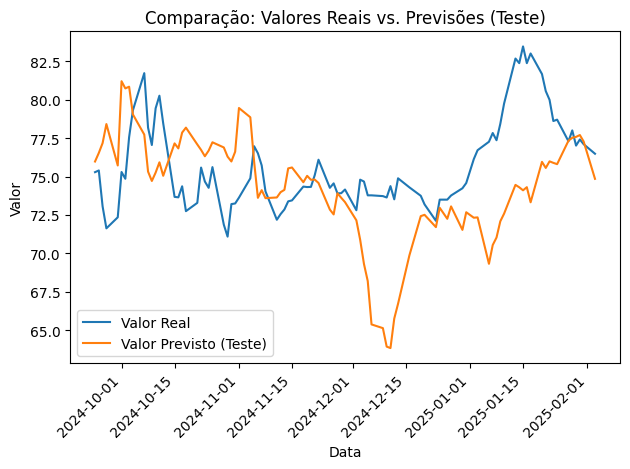

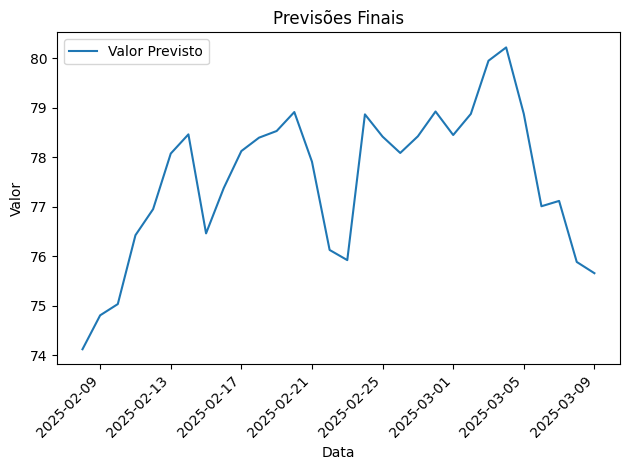

In [20]:
forecast = ForecastPetroleo()
forecast.predict_days(30)

In [21]:
!pip install sphinx



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
